In [1]:
import numpy as np
import pandas as pd

"""
Comparison for network Lorenz stochastic dynamics inference

"""

# Import the package:

from StochasticForceInference import *

 

In [2]:
Aadj = pd.read_csv('/Users/lana_g/Downloads/comparison/Lorenz2nodesAdj.csv',encoding='utf-8',header=None)
A = Aadj.values

In [3]:
x_data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_x_stochastic_gamma1_withlib.csv',encoding='utf-8',header=None)

In [4]:
T=2000
dt=0.01
tlist=np.linspace(0.01,T,int(T/dt))

In [5]:
xlist = x_data.iloc[:,:3].values.reshape(-1,1,3)
print("check:")
print(xlist.shape)

check:
(200000, 1, 3)


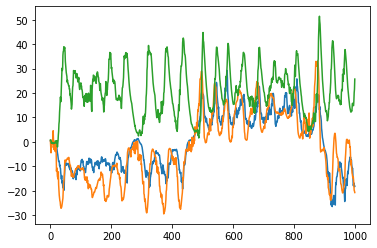

In [6]:
import matplotlib.pyplot as plt
plt.plot(xlist[:1000,0,:])

In [7]:
import numpy as np
import pandas as pd
import time
Start = time.time()
# Import the package:
from StochasticForceInference import *

 
################################################################
##### I. Prepare the data (here using a simulated model). ######


# # Diffusion parameters: a linear diffusion gradient (multiplicative noise)
# dim=3
# diffusion_coeff = 0.1
# D = diffusion_coeff *  np.identity(dim) 
# y = np.array([1.,2,1])
# D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# # Force field parameters (stochastic Lorenz process)
# r,b,s = 6.,1.,3.

# # force = lambda X : np.array([[ s*(x[2]-x[0]),
# #                                x[0]*x[2]-b*x[1],
# #                                r*x[0] - x[2] - x[1]*x[0]] for x in X ])

# # force = lambda X : np.array([[ 3*(x[1]-x[0]), 
# #                                 26.5*x[0]-x[1]-x[0]*x[2], 
# #                                 x[0]*x[1]-0.16*x[2] ]for x in X])

# # # Note: the "for" loop runs over particles/copies of the simulation;
# # #   it is not used here.

# # # Simulation parameters
# # initial_position = np.array([[0.1 for i in range(dim)]]) 
# dt = 0.01
# oversampling = 4
# # #prerun = 100
# Npts = 10000
# # tau = dt * Npts
# # tlist = np.linspace(0.,tau,Npts)

# # # Run the simulation using our OverdampedLangevinProcess class
# # np.random.seed(1)
# # X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling)

# # # Possibly blur a bit the data to mimic noise from the measurement
# # # device:
# # noise_amplitude = 0.0
# # noise = noise_amplitude * np.random.normal(size=X.data.shape)

# # # The input of the inference method is the "xlist" array, which has
# # # shape Nsteps x 1 x dim (the middle index is used for multiple
# # # particles with identical properties; we do not use it in this demo).
# # xlist = X.data + noise
# # tlist = X.t


xlist = xlist[:,0,:].reshape(-1,1,3)
print(xlist)
print(tlist)
print(xlist.shape, tlist.shape)



freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   #[start:stop:step]
center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()
End = time.time()
print("Time consuming:",End-Start)
#data_exact = StochasticTrajectoryData(X.data,X.t)

[[[  0.37148   0.50452   0.81538]]

 [[  0.37226  -2.4565    0.77826]]

 [[  0.14531  -4.4485    0.36446]]

 ...

 [[ -8.2534  -10.942    16.979  ]]

 [[ -9.3812  -11.095    16.262  ]]

 [[-10.294   -11.846    16.392  ]]]
[1.00000e-02 2.00000e-02 3.00000e-02 ... 1.99998e+03 1.99999e+03
 2.00000e+03]
(200000, 1, 3) (200000,)
1 3
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[1.05905042e+02 1.76855163e+01 6.25083573e-01]
 [1.76855163e+01 1.32597995e+02 1.86200165e-01]
 [6.25083573e-01 1.86200165e-01 1.89047613e+02]]
Entropy production: inferred/bootstrapped error 284564.4334990218 756.7885219782629
Drift information: inferred/bootstrapped error 80161.85744823258 400.68530656422274
Drift: squared typical error on projections: 0.012560726250621209
  - due to trajectory length: 0.0001871214125706455
  - due to discretization: 0.012373604838050563
Diffusion: squared typical error on projections: 2.570614562727414
  - due to trajectory length: 0.00018000

1 3


Text(0, 0.5, 'inferred F_mu(x)')

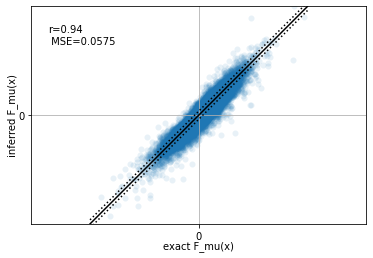

In [8]:
data_exact = StochasticTrajectoryData(xlist,tlist)
print(data_exact)
F_exact = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_F_stochastic_gamma1_all.csv',encoding='utf-8',header=None)
F_exact1 = F_exact.values[1:-1,:].reshape(-1,1,3)
#S.compare_to_exact(data_exact=data_exact,force_exact=F_exact)

indices = np.array([i for i in range(0,len(tlist)-2,1)])
ansatz_F_Ito  = [ S.F_ansatz(data.X_ito[i]) for i in indices ]

SFI_plotting_toolkit.comparison_scatter(F_exact1,ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel('exact F_mu(x)',labelpad=-1)
plt.ylabel('inferred F_mu(x)',labelpad=0)

In [9]:
npdata=np.array(ansatz_F_Ito).reshape(-1,3)

In [10]:
# ygoal = ansatz_F_Ito[0]
# for t in range(npdata[:].shape[0]):
#     tmp = ansatz_F_Ito[t]
#     ygoal = np.vstack((ygoal,tmp))

In [11]:
from ElementaryFunctionsPool import *
from ElementaryFunctions_Matrix import *

In [12]:
A = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz2nodesAdj.csv',encoding='utf-8',header=None)
A = A.values

In [13]:
Dim = 3
data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_x_stochastic_gamma1.csv',encoding='utf-8',header=None)

In [14]:
data = data.values

In [15]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     print(reg.coef_)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [16]:
Dim=3
Nnodes = 20
selfPolyOrder = 3
Matrix = ElementaryFunctions_Matrix(data, Dim, Nnodes, A, selfPolyOrder, coupledPolyOrder = 1, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False, RescalingIndex = False, CoupledPolynomialIndex = True, \
        CoupledTrigonometricIndex = True, CoupledExponentialIndex = False, CoupledFractionalIndex = False, \
            CoupledActivationIndex = False, CoupledRescalingIndex = False)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [17]:
Matrix = Matrix.iloc[1:-1,:]

In [18]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,0])

In [19]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


0.9989728808809077
Best threshold: 0.009


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [20]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 without constant.
x1x1x3        -0.000215
x2x3x3         0.000274
x2x2           0.002015
x1jMinusx1i    0.004667
x2jMinusx2i   -0.010604
x1j           -0.019698
x2x3           0.053772
x1x3          -0.166617
x1            -2.667633
x2             5.741826
dtype: float64


In [21]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,1])
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


0.9583393209563461
Best threshold: 0.023
Elementary functions discovered by Phase 1 without constant.
expx2     1.000000e-10
expx1     1.000000e-10
x1x1x1   -1.275173e-04
x2x3x3   -1.500305e-03
x1x3x3   -7.672920e-03
x2x3     -9.168394e-03
x1x3     -2.089058e-02
x1j       1.217396e-01
x2        3.296565e-01
x1        6.175915e+00
dtype: float64


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [22]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,2])
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


0.9996547338048837
Best threshold: 0.004
Elementary functions discovered by Phase 1 without constant.
expx1          1.000000e-10
x2x2x2        -1.624474e-05
x1ix1j         2.374814e-05
x1x2x3         3.634576e-05
x1x1x3         1.774887e-04
x2ix2j         2.957626e-04
x3jMinusx3i    1.194182e-02
x3x3          -1.242623e-02
x1x2           4.767456e-01
x3            -2.641161e+00
dtype: float64


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
